## Transect plots

In [1]:
#from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import xarray as xr
import os
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean
import cmocean.cm as cmo
import gsw
from itertools import cycle


# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

lightthermal = cmocean.tools.crop_by_percent(cmo.thermal, 5, which='min', N=None)

plt.close(fig='all') # plots stay open with widget until closed; might have to run this often

#matplotlib.get_configdir()
plt.style.use('/Users/North/.matplotlib/manuscript.mplstyle')

T_range = np.array((15,18))
S_range = np.array((35.,35.6))
N_range = np.array((-5,-3))
sigma_range = np.array((24.2,27.2))
sigma_levels = np.arange(sigma_range[0]-0.2,sigma_range[1]+.2,0.05)
theta_levels = np.arange(T_range[0],T_range[1],0.5)
U_range = np.array((-0.5,0.5))
mld_level = 0.1

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela") # need to set working directory to get .nc file access
sadcp_nc_dir = './netcdf_files/'
figure_dir = './figures/paper/'
import src.calc_Instabilities as ci


In [2]:
def read_in_scan_sadcp(transect_name):
    # actually just sadcp data, but putting them in same Dict
    scan_sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'scan_sadcp_transects_1km_'+transect_name+'.nc')) 
    scan_sadcp_transects_xkm = scan_sadcp_transects_xkm.set_index(xy=['x_m','lat','lon','time','time_secs'])
    return scan_sadcp_transects_xkm

def nice_plot(ds,trans_name,si,darklines=False):
    if 'xy' in ds[trans_name]:
        ds[trans_name] = ds[trans_name].reset_index('xy').swap_dims({'xy': 'x_m'})
    if darklines: lcol = ('0.2','k')
    else: lcol = ('0.75','w')
    # add pot. density contour lines
    ds[trans_name].sigma_0.plot.contour(x='x_km',ax=axs[si],levels = sigma_levels,colors=lcol[0],linewidths=1)
    # add 16.5 and 17 degC contour to match SST maps
    ds[trans_name].CT.plot.contour(x='x_km',ax=axs[si],levels = np.array((16.5,17)),colors= 'k',linewidths=2)
    ds[trans_name].CT.plot.contour(x='x_km',ax=axs[si],levels = np.array((16.5,17)),colors= 'w',linewidths=1.5)
    # Mixed layer depth
    ds[trans_name]['MLD'] = (ds[trans_name].sigma_0 - ds[trans_name].sigma_0.sel(z=ds[trans_name].z.max(), method='nearest') )
    #ds[trans_name]['MLD'].reset_index('xy').plot.contour(x='x_km',ax=axs[si],levels=[0.01, 0.1, 0.25], colors='0.05', linewidths=1.5)
    ds[trans_name]['MLD'].plot.contour(x='x_km',ax=axs[si],levels=[0.1], colors=lcol[1], linewidths=3.)
    return ds

def add_lats_on_top(ds,axs,dim='x_m'):
    # add second axes with latitudes
    ax2 = axs.twiny() 
    ax2.set_xlim(axs.axis()[0], axs.axis()[1])
    # set tick values to be the matching latitude values
    xtick_vals2 = (ds.interp({dim:axs.get_xticks()}).lat) #.reset_index('xy').swap_dims({'xy': 'x_km'})
    ax2.set_xticklabels(xtick_vals2.values.round(2))
    return ax2

def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    rpn: copied on 25.9.2010 from: https://gist.github.com/tacaswell/9643166
    Walks through axes and labels each.
    kwargs are collected and passed to `annotate`
    Parameters
    ----------
    fig : Figure
         Figure object to work on
    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.
    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_lowercase
        
    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (.9, .9)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc,
                    xycoords='axes fraction',
                    **kwargs)
        
def calc_interp2lat(var_w_v_x_fo):
    # need distance along lat only, to make it compatible with u
    if var_w_v_x_fo.lat[0]<var_w_v_x_fo.lat[-1]:
        # +/- 0.01 to avoid nan at ends
        new_lat = np.arange(var_w_v_x_fo.lat[0]+0.01,var_w_v_x_fo.lat[-1]-0.01,0.01)
    else:
        new_lat = np.arange(var_w_v_x_fo.lat[0]-0.01,var_w_v_x_fo.lat[-1]+0.01,-0.01)
    if 'xy' in var_w_v_x_fo:
        var_w_v_x_fo = var_w_v_x_fo.reset_index('xy').swap_dims({'xy':'x_m'})
    var_w_v_x_fo = var_w_v_x_fo.swap_dims({'x_m':'lat'})
    var_w_v_x_fo = var_w_v_x_fo.interp(lat=new_lat).swap_dims({'lat': 'x_m'})
    new_dx_m = gsw.distance(var_w_v_x_fo.lon.values,
                            var_w_v_x_fo.lat.values,p=0)
    dist = np.cumsum((np.append(np.array(0),new_dx_m)))
    var_w_v_x_fo = var_w_v_x_fo.assign_coords(x_m=dist)
    ## rebuild time
    #var_w_v_x_fo = var_w_v_x_fo.assign_coords(time=var_w_v_x_fo.time_secs.astype('datetime64'))
    return var_w_v_x_fo
    
def calc_Ro_EPV_Rib_transect(trans_in,u_var='u',interp2lat=True):
    trans_in = ci.calc_coriolis(trans_in)
    trans_in, grid = ci.setup_dataset_grid(trans_in)
    trans_in = ci.calc_N2_M2(trans_in, grid)
    trans_in = ci.calc_dv_dx(trans_in, grid, vel_name=u_var)
    trans_in = ci.calc_dv_dz(trans_in, grid, vel_name=u_var)
    if u_var=='along_fil':
        trans_in['relative_vorticity'] =  trans_in.dv_dx        
    else:
        if interp2lat:
            trans_in = calc_interp2lat(trans_in) #calc_relative_vorticity(trans_in,u_var='u')
        if u_var=='u':
            trans_in['relative_vorticity'] =  trans_in.dv_dx
        elif u_var=='across':
            if trans_in.TransectDirection == 'N-S':
                trans_in['relative_vorticity'] =  trans_in.dv_dx
            if trans_in.TransectDirection == 'S-N':
                trans_in['relative_vorticity'] =  trans_in.dv_dx
    trans_in['Ro'] = trans_in['relative_vorticity']/trans_in.fo
    # from Adams et al. 2017, Equation 15
    trans_in = ci.calc_ertel_potential_vorticity(trans_in)
    trans_in = ci.calc_Ri_Balanced(trans_in,grid)
    if u_var=='along_fil':
        trans_in = ci.SI_GI_Check(trans_in,grid)
    return trans_in
        
def plot_Ro_transect(trans_in,ax,log_scale=True):
    if 'x_km' not in trans_in:
        trans_in = trans_in.assign_coords(x_km=trans_in.x_m/1e3 )
    if log_scale:
        pout = np.log(np.abs(trans_in['Ro'])).plot(x='x_km',vmin=-1,vmax=0,levels=6,ylim=(-100,0),ax=ax,
                                                             add_colorbar=False,rasterized=True,cmap='Blues')
    else:
        pout = trans_in['Ro'].plot(x='x_km',vmin=-1,vmax=1,levels=21,ylim=(-100,0),ax=ax,
                                   add_colorbar=False,rasterized=True,cmap=cmo.balance)
    return trans_in,pout

def nice_plot_4fronts(i,ScanTransect_Fronts,axs,var_range, h_grad_on=False, colorbar_on=False, cb_label=None, lat_on_top=False):
    lcol = ('0.2','k')
    ScanTransect_Fronts.sigma_0.plot.contour(levels = sigma_levels, colors=lcol[0],linewidths=2,ax=axs,x='x_km')
    # Mixed layer depth
    ScanTransect_Fronts.MLD.plot.contour(levels = [0.1], colors=lcol[1],linewidths=3,ax=axs,x='x_km')
    # add horizontal gradient as shading
    if h_grad_on : 
        # add horizontal gradient as shading
        h_grad=np.abs(ScanTransect_Fronts.db_dx.
                where(ScanTransect_Fronts.MLD<mld_level))
        h_grad.where(h_grad>1e-7).plot(x='x_km',ax=axs,alpha=0.25,colors='k',levels=[1e-9,2e-9],add_colorbar=False,ylim=y_lim)
    if i==0 and colorbar_on: 
        cbaxes = inset_axes(axs, width="30%", height="5%", loc=1) 
        mappable = axs.collections[0]
        if cb_label is None:
            cbp = plt.colorbar(mappable, cax=cbaxes, orientation='horizontal',
                               ticks=np.linspace(var_range[0],var_range[1],3))
        else:
            cbp = plt.colorbar(mappable, cax=cbaxes, orientation='horizontal')#,extend='neither')
            cbp.ax.set_xticklabels(cb_label)  
        axs.set_ylabel('Depth [m]')
    elif i==0 and colorbar_on==False:
        axs.set_ylabel('Depth [m]')
    else:
        axs.set_yticklabels('')
        axs.set_ylabel('')
        cbaxes = None
    if str(ScanTransect_Fronts.Transect.values)[4:]=='north': axs.invert_xaxis()
    if lat_on_top: add_lats_on_top(ScanTransect_Fronts.swap_dims({'x_m': 'x_km'}),axs,dim='x_km')
    axs.set_title('') # add title

In [3]:
# ====== Load in data

# ====== load SADCP and Scanfish data for transects that cross filament
# cut ScanTransect to focus on filament
scan_sadcp_transects_1km_filament = OrderedDict() # Preallocate output dictionary
scan_sadcp_transects_1km_filament['ScanTransect1'] = (read_in_scan_sadcp('ScanTransect1').reset_index('xy').swap_dims({'xy':'x_m'}).
                                                      sel(x_m=slice(12e3,65.5e3)))
scan_sadcp_transects_1km_filament['ScanTransect1'] = scan_sadcp_transects_1km_filament['ScanTransect1'].assign_coords(
    x_m=scan_sadcp_transects_1km_filament['ScanTransect1'].x_m-scan_sadcp_transects_1km_filament['ScanTransect1'].x_m[0])
scan_sadcp_transects_1km_filament['ScanTransect2'] = (read_in_scan_sadcp('ScanTransect2').reset_index('xy').swap_dims({'xy':'x_m'}).
                                                      sel(x_m=slice(9.5e3,100.5e3)))
scan_sadcp_transects_1km_filament['ScanTransect2'] = scan_sadcp_transects_1km_filament['ScanTransect2'].assign_coords(
    x_m=scan_sadcp_transects_1km_filament['ScanTransect2'].x_m-scan_sadcp_transects_1km_filament['ScanTransect2'].x_m[0])

for key in scan_sadcp_transects_1km_filament:
    scan_sadcp_transects_1km_filament[key] = (scan_sadcp_transects_1km_filament[key]
                                              .assign_coords(x_km=scan_sadcp_transects_1km_filament[key].x_m/1e3))


In [4]:
# calculate Ro for transects
# interpolates along lat, changing size, so create a new dataset to not overwrite
scan_sadcp_transects_1km_filament['ScanTransect1'] = calc_Ro_EPV_Rib_transect(scan_sadcp_transects_1km_filament['ScanTransect1'],
                                                                      u_var='u',interp2lat=True) 
scan_sadcp_transects_1km_filament['ScanTransect2'] = calc_Ro_EPV_Rib_transect(scan_sadcp_transects_1km_filament['ScanTransect2'],
                                                                      u_var='across',interp2lat=False) 


####    Transects across the filament: plotting T, S, N^2 and U, V, Ro

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


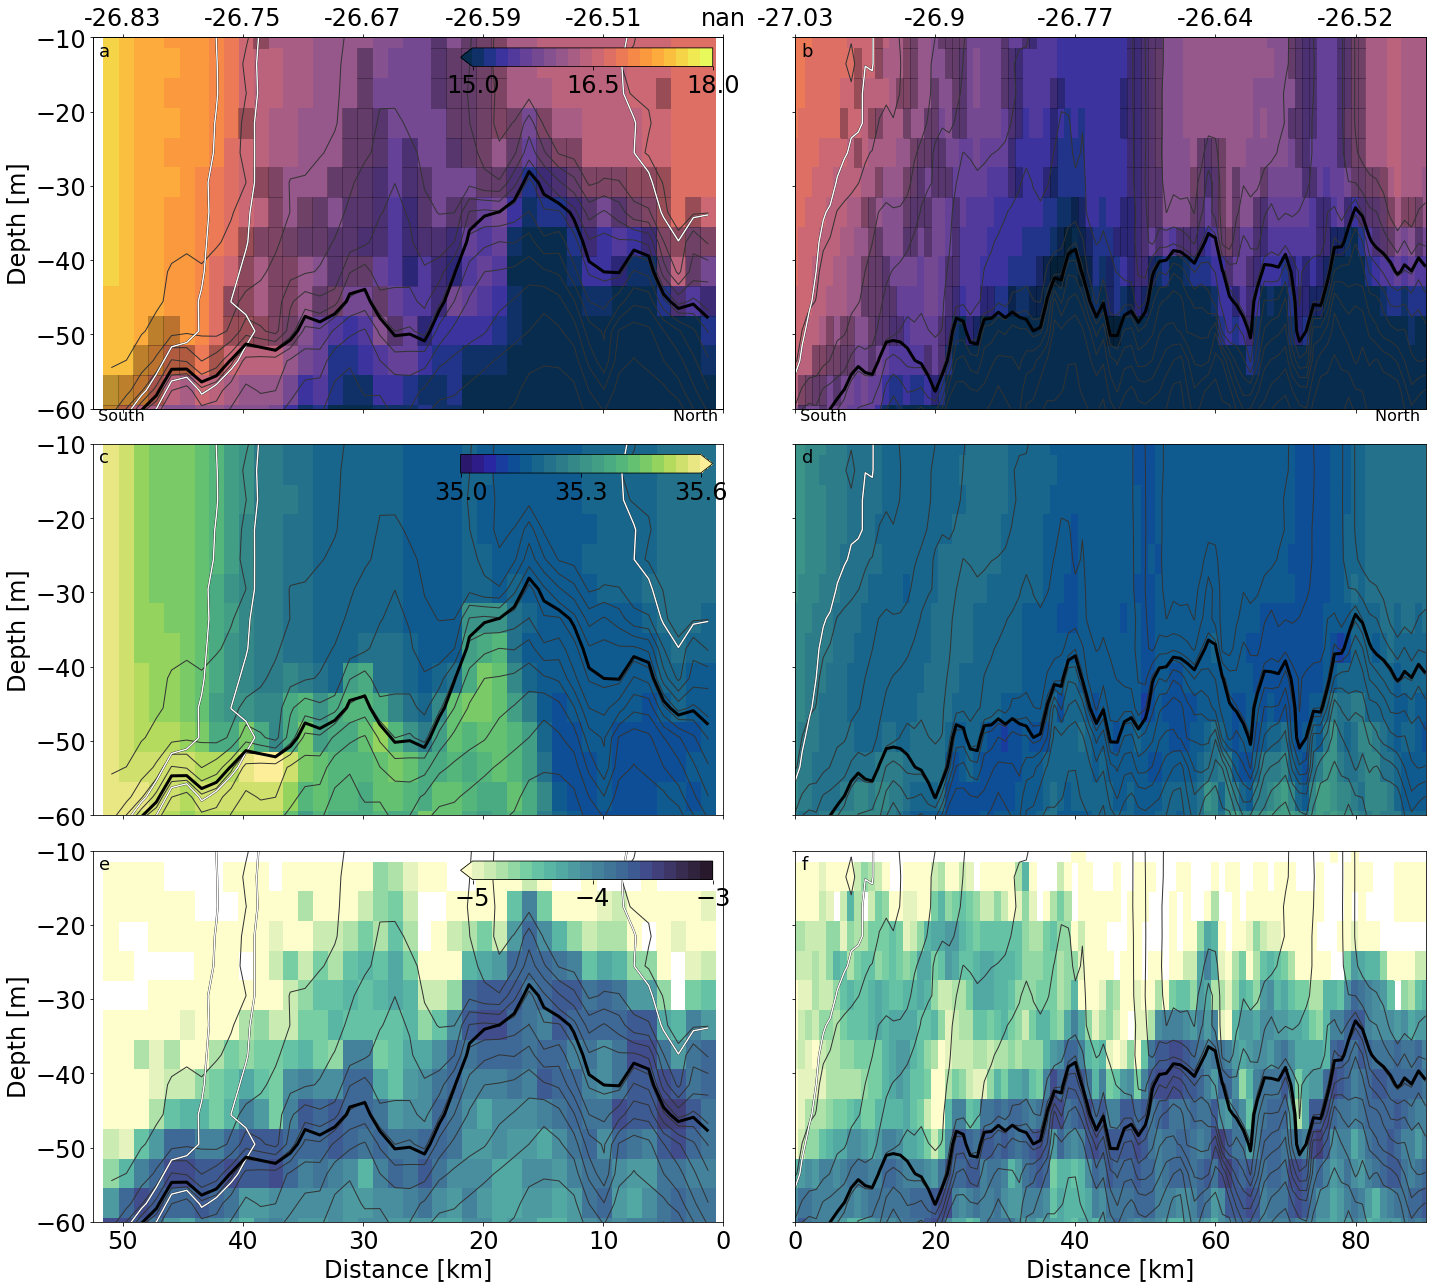

In [6]:
x_lim, y_lim = [65-12.5,0], [-60,-10]
x_lim2 = [0,90]

# setting up figure and subplots
si, nrows, ncols =  0, 3, 2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()

#=== Conservative temperature
# 1st Scanfish transect (offshore)
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].CT.plot(x='x_km',ax=axs[si],vmin=T_range[0],vmax=T_range[1],
                                                                                  levels=21,cmap=lightthermal,add_colorbar=False,
                                                                                 rasterized=True)
# a few standard setup changes to improve plot
scan_sadcp_transects_1km_filament = nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', 0, darklines=True)
# add horizontal buoyancy gradient as shading
h_grad=np.abs(scan_sadcp_transects_1km_filament['ScanTransect1'].db_dx.
        where(scan_sadcp_transects_1km_filament['ScanTransect1'].MLD<mld_level))
h_grad.where(h_grad>1e-7).plot(x='x_km',ax=axs[si],alpha=0.25,colors='k',levels=[1e-9,2e-9],add_colorbar=False)
# add colorbar
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(T_range[0],T_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('')
axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')
# add north-south end of transect
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
# put latitude values on top x-axis
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect1'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')
    
# 2nd Scanfish transect (nearshore)
si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].CT.plot(x='x_km',ax=axs[si],vmin=T_range[0],vmax=T_range[1],
                                                                                  levels=21,cmap=lightthermal,add_colorbar=False,
                                                                                 rasterized=True)
scan_sadcp_transects_1km_filament=nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si, darklines=True)
# add horizontal gradient as shading
h_grad = np.abs(scan_sadcp_transects_1km_filament['ScanTransect2'].db_dx.
                where(scan_sadcp_transects_1km_filament['ScanTransect2'].MLD<mld_level))
h_grad.where(h_grad>1e-7).plot(x='x_km',ax=axs[si],alpha=0.25,colors='k',levels=[1e-9,2e-9],add_colorbar=False)
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)
axs[si].set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_xticklabels('')
# add night (when measurements were taken at night)
x_night = (scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m':'time'}).
           sel(time=slice('2016-11-19T19:30','2016-11-20T06:00:00')).x_km.values)
axs[si].axvspan(x_night[0],x_night[-1], facecolor='k', alpha=0.5,zorder=0)
# add north-south
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')

#=== Absolute Salinity
si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].SA.plot(x='x_km',ax=axs[si],vmin=S_range[0],vmax=S_range[1],
                                                                                  levels=21,cmap=cmo.haline,add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', si, darklines=True)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(S_range[0],S_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('')
axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].SA.plot(x='x_km',ax=axs[si],vmin=S_range[0],vmax=S_range[1],
                                                                 levels=21,cmap=cmo.haline,add_colorbar=False,
                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si, darklines=True)
axs[si].set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_xticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

#=== Vertical Buoyancy Gradient
si = si+1
p1 = np.log10(scan_sadcp_transects_1km_filament['ScanTransect1'].db_dz).plot(x='x_km',ax=axs[si],vmin=N_range[0],
                                                                             vmax=N_range[1],levels=21,cmap=cmo.deep,
                                                                             add_colorbar=False, rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', si, darklines=True)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(N_range[0],N_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_ylabel('Depth [m]')
axs[si].set_xlabel('Distance [km]')

si = si+1
p1 = np.log10(scan_sadcp_transects_1km_filament['ScanTransect2'].db_dz).plot(x='x_km',ax=axs[si],vmin=N_range[0],
                                                                             vmax=N_range[1],levels=21,cmap=cmo.deep,
                                                                             add_colorbar=False, rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si, darklines=True)
axs[si].set_ylabel('')
axs[si].set_xlabel('Distance [km]')
axs[si].set_yticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','d','e','f','','','','','','','','')),loc=(0.01,0.95),size=18)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_sections_filament_CT_SA_sigma_N2.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


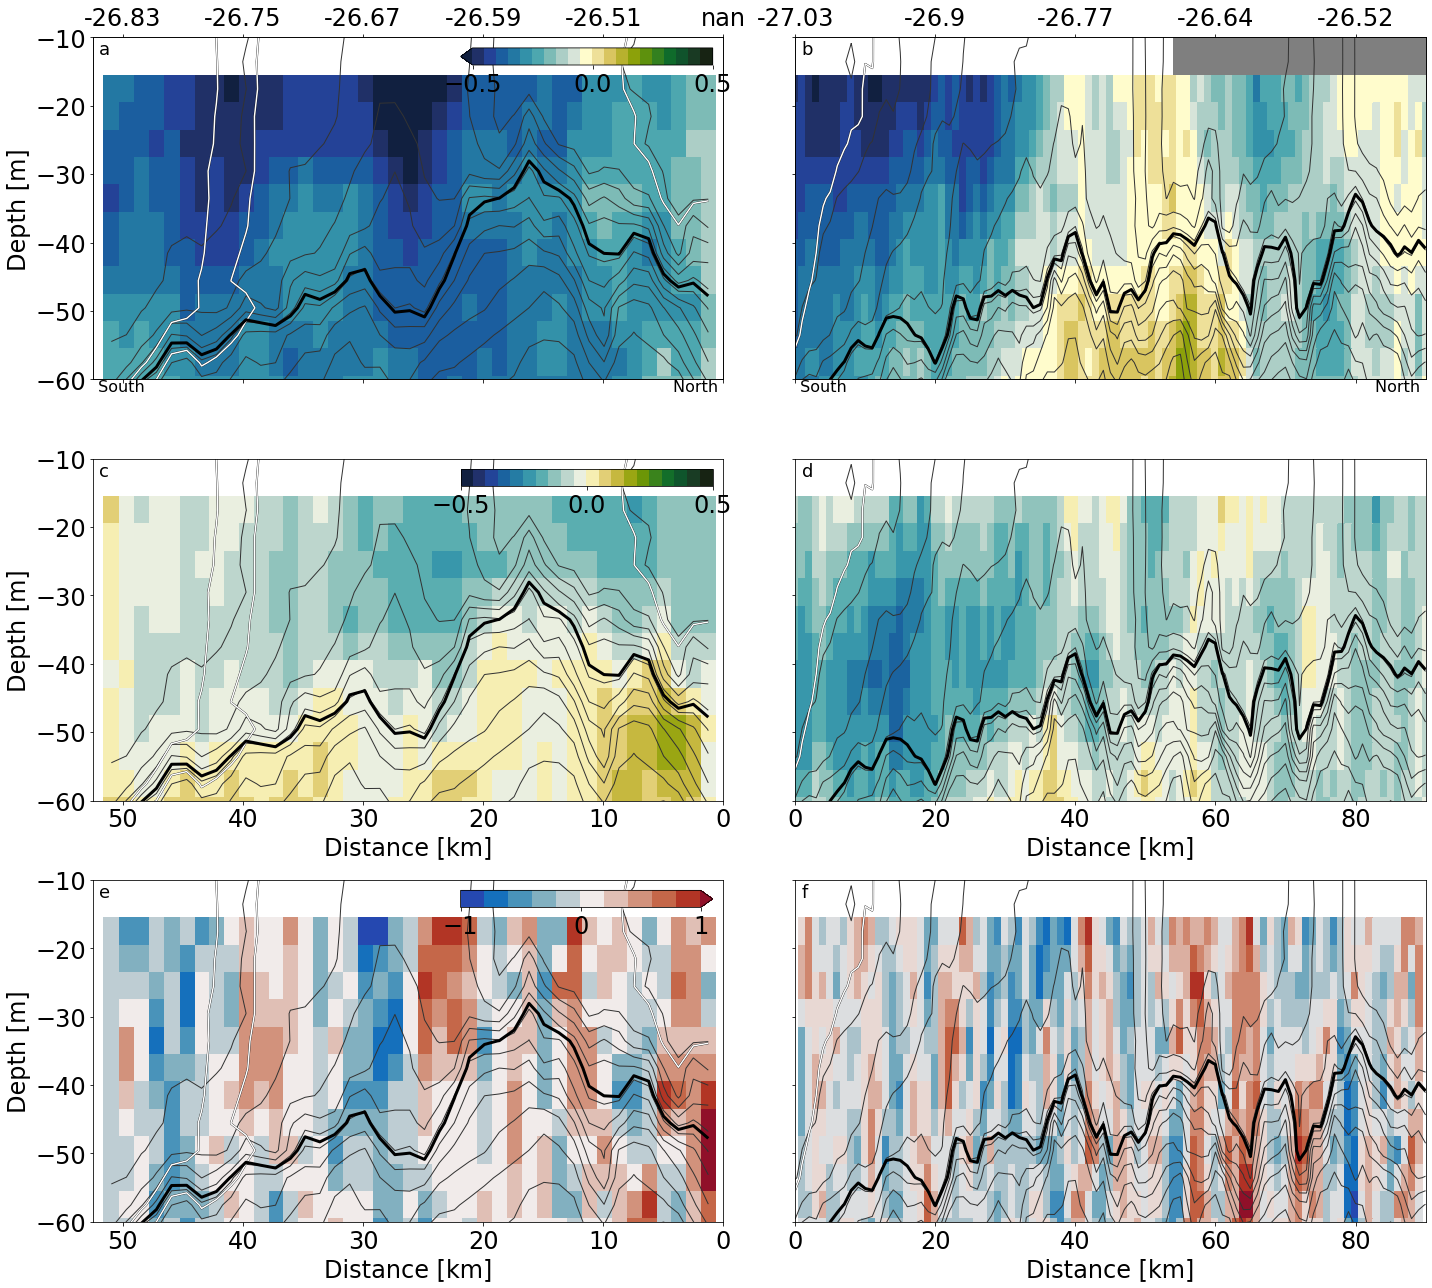

In [6]:
x_lim, y_lim = [65-12.5,0], [-60,-10]
x_lim2 = [0,90]

si, nrows, ncols =  0, 3, 2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()

#=== U
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].u.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap=cmo.delta,add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', 0, darklines=True)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(U_range[0],U_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('')
axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')
# add north-south
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect1'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')
    
si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].across.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap=cmo.delta,add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si, darklines=True)
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)
axs[si].set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_xticklabels('')
# add night
x_night = (scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m':'time'}).
           sel(time=slice('2016-11-19T19:30','2016-11-20T06:00:00')).x_km.values)
axs[si].axvspan(x_night[0],x_night[-1], facecolor='k', alpha=0.5,zorder=0)
# add north-south
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')

#=== V
si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].v.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap=cmo.delta,add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', si, darklines=True)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(U_range[0],U_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('Distance [km]')
#axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].along.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap=cmo.delta,add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si, darklines=True)
axs[si].set_xlabel('Distance [km]')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
#axs[si].set_xticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

#=== Ro
si = si+1
Range = (-1,1)
lightbal = cmocean.tools.crop_by_percent(cmo.balance, 25, which='both', N=None)
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].Ro.plot(x='x_km',ax=axs[si],vmin=Range[0],vmax=Range[1],
                                                                                  levels=11,cmap=lightbal,add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', si, darklines=True)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(Range[0],Range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('Distance [km]')
#axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].Ro.plot(x='x_km',ax=axs[si],vmin=Range[0],vmax=Range[1],
                                                                                  levels=11,cmap=lightbal,add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si, darklines=True)
axs[si].set_xlabel('Distance [km]')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
#axs[si].set_xticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','d','e','f','','','','','','','','','','','','','')),
              loc=(0.01,0.95),size=18)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_sections_filament_u_v_Ro.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

####    Transects across the filaments: plotting Ri, EPV and submeso instabilities

In [5]:
# rearrange transect data so that x-axis is across front, and y-axis is along front; separate each transect into 2 fronts

# split transects into two fronts
ST1_south = np.array((24e3,30e3,50e3)) # start, middle of front (based on M^2 max) and middle of filament
ST1_north = np.array((0,20e3,26e3))  
ST2_south = np.array((0,30e3,40e3)) 
ST2_north = np.array((40e3,50e3,70e3))  

ST1_south = np.array((24e3,48e3,48e3)) # start, middle of front (based on M^2 max) and middle of filament
ST1_north = np.array((0,0,26e3))  
ST2_south = np.array((0,0,40e3)) 
ST2_north = np.array((40e3,70e3,70e3))  

# interp to same x values to combine transects into 1 dataset
new_xm = np.arange(-30e3,11e3,1e3)
new_xm = np.arange(0,41e3,1e3)

# interpolates along lat, so that x/y-axis corresponds directly to u/v velocity components
scan_sadcp_transects_1km_filament['ScanTransect1'] = calc_interp2lat(scan_sadcp_transects_1km_filament['ScanTransect1'])

# for each transect, select section of interest and reset distance across front values, as well as velocity
ScanTransect1_south = scan_sadcp_transects_1km_filament['ScanTransect1'].sel(x_m=slice(ST1_south[0],ST1_south[-1]))
ScanTransect1_south = ScanTransect1_south.assign_coords(x_m=ST1_south[1]-ScanTransect1_south.x_m).sortby('x_m').interp(x_m=new_xm)
ScanTransect1_south = ScanTransect1_south.drop_vars(['across','along']).rename_vars({'u':'along_fil'}).rename_vars({'v':'across_fil'})

ScanTransect1_north = scan_sadcp_transects_1km_filament['ScanTransect1'].sel(x_m=slice(ST1_north[0],ST1_north[-1]))
ScanTransect1_north = ScanTransect1_north.assign_coords(x_m=ScanTransect1_north.x_m-ST1_north[1]).sortby('x_m').interp(x_m=new_xm)
ScanTransect1_north = ScanTransect1_north.drop_vars(['across','along']).rename_vars({'u':'along_fil'}).rename_vars({'v':'across_fil'})
ScanTransect1_north['across_fil'] = -1*ScanTransect1_north.across_fil

# for this transect, using across/along velocity component, so x/y-axis are not changed
ScanTransect2_south = scan_sadcp_transects_1km_filament['ScanTransect2'].sel(x_m=slice(ST2_south[0],ST2_south[-1]))
ScanTransect2_south = ScanTransect2_south.assign_coords(x_m=ScanTransect2_south.x_m-ST2_south[1]).sortby('x_m').interp(x_m=new_xm)
ScanTransect2_south = ScanTransect2_south.drop_vars(['u','v']).rename_vars({'across':'along_fil'}).rename_vars({'along':'across_fil'})

ScanTransect2_north = scan_sadcp_transects_1km_filament['ScanTransect2'].sel(x_m=slice(ST2_north[0],ST2_north[-1]))
ScanTransect2_north = ScanTransect2_north.assign_coords(x_m=ST2_north[1]-ScanTransect2_north.x_m).sortby('x_m').interp(x_m=new_xm)
ScanTransect2_north = ScanTransect2_north.drop_vars(['u','v']).rename_vars({'across':'along_fil'}).rename_vars({'along':'across_fil'})
ScanTransect2_north['across_fil'] = -1*ScanTransect2_north.across_fil

ScanTransect_Fronts = xr.concat([ScanTransect1_south, ScanTransect1_north, ScanTransect2_south, ScanTransect2_north],dim='Transect')
ScanTransect_Fronts = ScanTransect_Fronts.assign_coords(Transect = list(('ST1_south','ST1_north','ST2_south','ST2_north')))
ScanTransect_Fronts = ScanTransect_Fronts.assign_coords(x_km = ScanTransect_Fronts.x_m/1e3)
ScanTransect_Fronts['along_fil'] = -1*ScanTransect_Fronts.along_fil

# depth of mixed layer
ScanTransect_Fronts['MLD'] = (ScanTransect_Fronts.sigma_0 - ScanTransect_Fronts.sigma_0.sel(z=ScanTransect_Fronts.z.max(), 
                                                                                            method='nearest') )
# add horizontal buoyancy gradient as shading
h_grad=np.abs(ScanTransect_Fronts.db_dx.where(ScanTransect_Fronts.MLD<mld_level))

# calculate Ro,EPV,Ri for transects
ScanTransect_Fronts = calc_Ro_EPV_Rib_transect(ScanTransect_Fronts.drop_dims(['x_m_left','z_left']),
                                               u_var='along_fil',interp2lat=False);


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


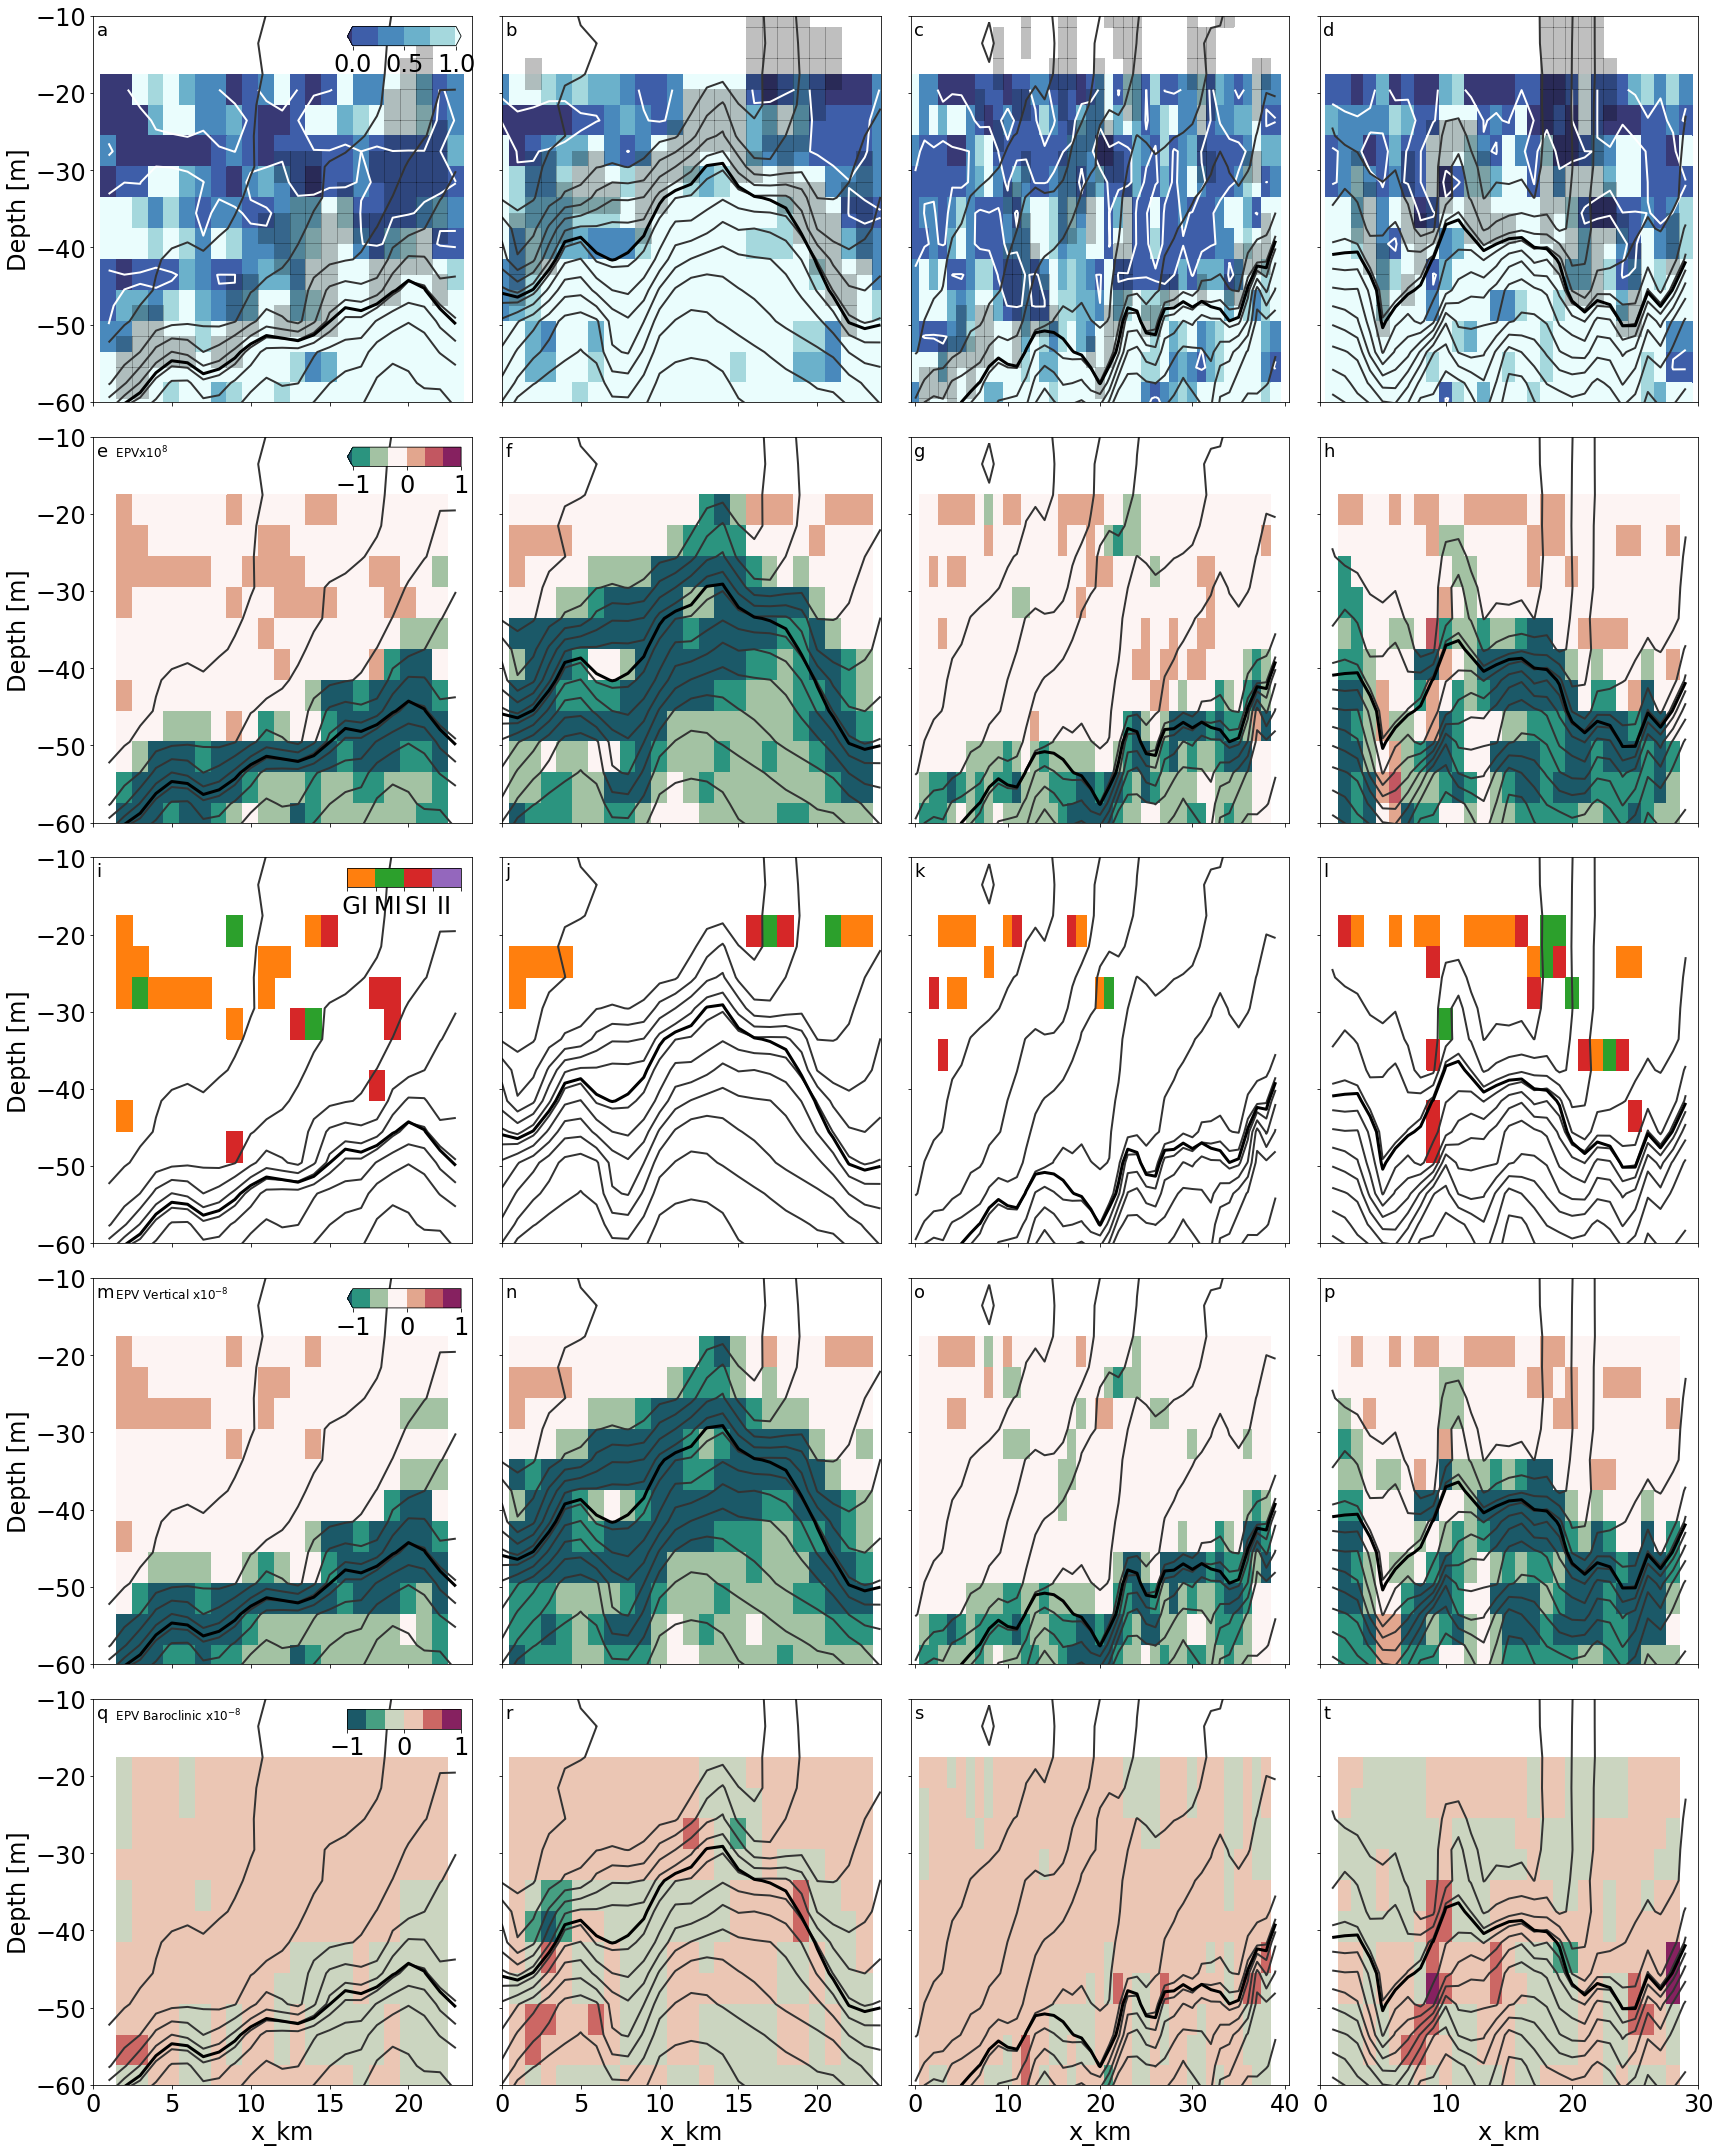

In [9]:
# updated version: removing Rib, combining with breakdown figure

x_lim, y_lim = [0,40], [-60,-10]
x_lim2 = [0,90]
mld_level = 0.1

si, nrows, ncols =  0, 5, 4
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*6.,nrows*6))
axs = axs.ravel()

si = 0  

### ==== Rig =====
# loop through each front of the 2 scanfish transects
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (0,1) # colorbar range
    lightice = cmocean.tools.crop_by_percent(cmo.ice, 25, which='min', N=None) # setup colormap
    # plot Rig as color contours
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rig.plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=5,ax=axs[si],ylim=y_lim,
                                                         add_colorbar=False,rasterized=True,cmap=lightice)
    # adding line contour of Rig=0.25
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rig.plot.contour(x='x_km',levels=[0.25],colors='w',ax=axs[si],linestyles='solid',
                                                                  ylim=y_lim,add_colorbar=False,rasterized=True)
    # improvement the look of the plot
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=True,colorbar_on=True)
    #if i == 0:
    #    axs[si].text(0.05,0.98,' Ri$^g$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1

### ==== EPV =====
lightcurl = cmocean.tools.crop_by_percent(cmo.curl, 25, which='both', N=None)
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (-1,1)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).Ertel_Potential_Vorticity*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPVx10$^{8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1
    
### ==== Instability =====
#si = 0  
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (1,5)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).StableGravMixSymInert.
          where(ScanTransect_Fronts.sel(Transect=Trans).Ertel_Potential_Vorticity>0).
          where(ScanTransect_Fronts.sel(Transect=Trans).StableGravMixSymInert>0).
          plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=5,ax=axs[si],ylim=y_lim,
               add_colorbar=False,rasterized=True,colors=plt.cm.tab10.colors[1:5]))
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,
                                    colorbar_on=False,lat_on_top=False)    
    if i == 0:
        cbaxes = inset_axes(axs[si], width="30%", height="5%", loc=1) 
        cbp = plt.colorbar(p1, cax=cbaxes, orientation='horizontal')
        cbp.ax.set_xticklabels(['  GI','   MI','   SI','   II'])  # relabeling colorbar
        #axs[si].text(0.05,0.98,' Instability Analysis', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',
        #             fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1

### ==== EPV breakdown =====
var_range = (-1,1)    
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).EPV_vertical*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPV Vertical x10$^{-8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',
                     fontsize=12)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    si = si+1

for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    #lightcurl = cmocean.tools.crop_by_percent(cmo.curl, 25, which='both', N=None)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).EPV_baroclinic*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPV Baroclinic x10$^{-8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',
                     fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    si = si+1
# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t'
                                   ,'','','','','','','','')),loc=(0.01,0.95),size=18)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_sections_filament_Ri_EPV_Instabilities_and_Breakdown.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


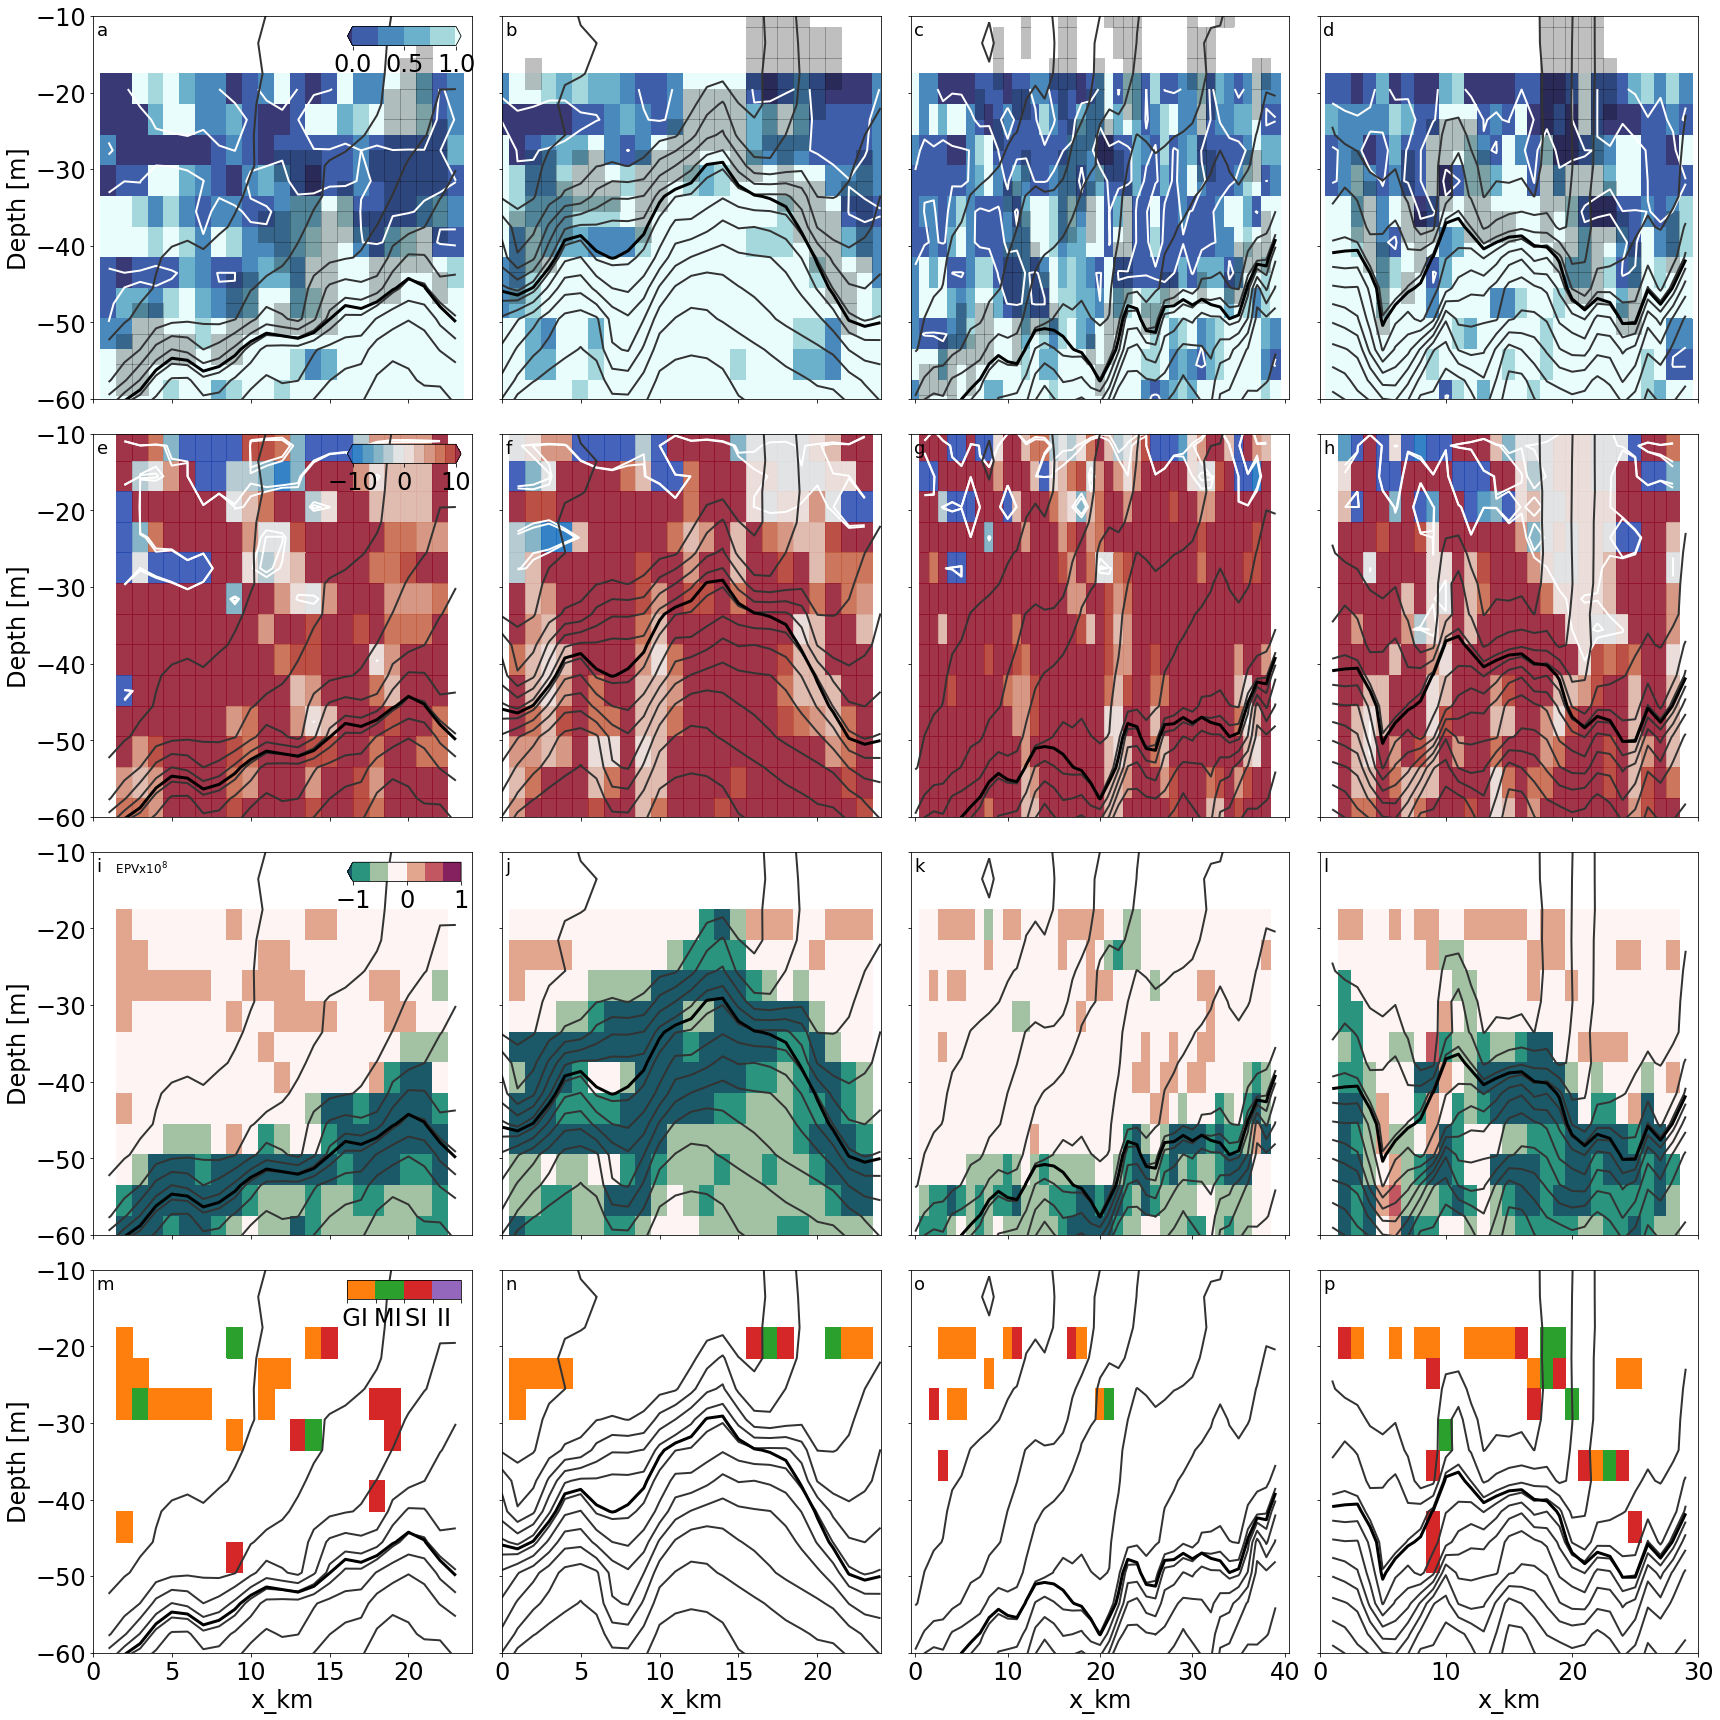

In [7]:
x_lim, y_lim = [0,40], [-60,-10]
x_lim2 = [0,90]
mld_level = 0.1

si, nrows, ncols =  0, 4, 4
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*6.,nrows*6))
axs = axs.ravel()

si = 0  

### ==== Rig =====
# loop through each front of the 2 scanfish transects
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (0,1) # colorbar range
    lightice = cmocean.tools.crop_by_percent(cmo.ice, 25, which='min', N=None) # setup colormap
    # plot Rig as color contours
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rig.plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=5,ax=axs[si],ylim=y_lim,
                                                         add_colorbar=False,rasterized=True,cmap=lightice)
    # adding line contour of Rig=0.25
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rig.plot.contour(x='x_km',levels=[0.25],colors='w',ax=axs[si],linestyles='solid',
                                                                  ylim=y_lim,add_colorbar=False,rasterized=True)
    # improvement the look of the plot
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=True,colorbar_on=True)
    #if i == 0:
    #    axs[si].text(0.05,0.98,' Ri$^g$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1

### ==== Rib =====
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (-10,10)
    lightdiff = cmocean.tools.crop_by_percent(cmo.tarn, 50, which='both', N=None)
    lightbal = cmocean.tools.crop_by_percent(cmo.balance, 25, which='both', N=None)
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rib.plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=11,ax=axs[si],ylim=y_lim,
                                                         add_colorbar=False,rasterized=True,cmap=lightbal,alpha=0.85)
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rib.plot.contour(x='x_km',levels=[-1,1],colors='w',linestyles='solid',ax=axs[si],
                                                                  ylim=y_lim,add_colorbar=False,rasterized=True)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    #if i == 0:
    #    axs[si].text(0.05,0.98,' Ri$^b$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1

### ==== EPV =====
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (-1,1)
    lightcurl = cmocean.tools.crop_by_percent(cmo.curl, 25, which='both', N=None)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).Ertel_Potential_Vorticity*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPVx10$^{8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1
    
### ==== Instability =====
#si = 0  
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (1,5)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).StableGravMixSymInert.
          where(ScanTransect_Fronts.sel(Transect=Trans).Ertel_Potential_Vorticity>0).
          where(ScanTransect_Fronts.sel(Transect=Trans).StableGravMixSymInert>0).
          plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=5,ax=axs[si],ylim=y_lim,
               add_colorbar=False,rasterized=True,colors=plt.cm.tab10.colors[1:5]))
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,
                                    colorbar_on=False,lat_on_top=False)    
    if i == 0:
        cbaxes = inset_axes(axs[si], width="30%", height="5%", loc=1) 
        cbp = plt.colorbar(p1, cax=cbaxes, orientation='horizontal')
        cbp.ax.set_xticklabels(['  GI','   MI','   SI','   II'])  # relabeling colorbar
        #axs[si].text(0.05,0.98,' Instability Analysis', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',
        #             fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    si = si+1

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p'
                                   ,'','','','','','','','')),loc=(0.01,0.95),size=18)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_sections_filament_Ri_EPV_Instabilities.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/plot/plot.py:934: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


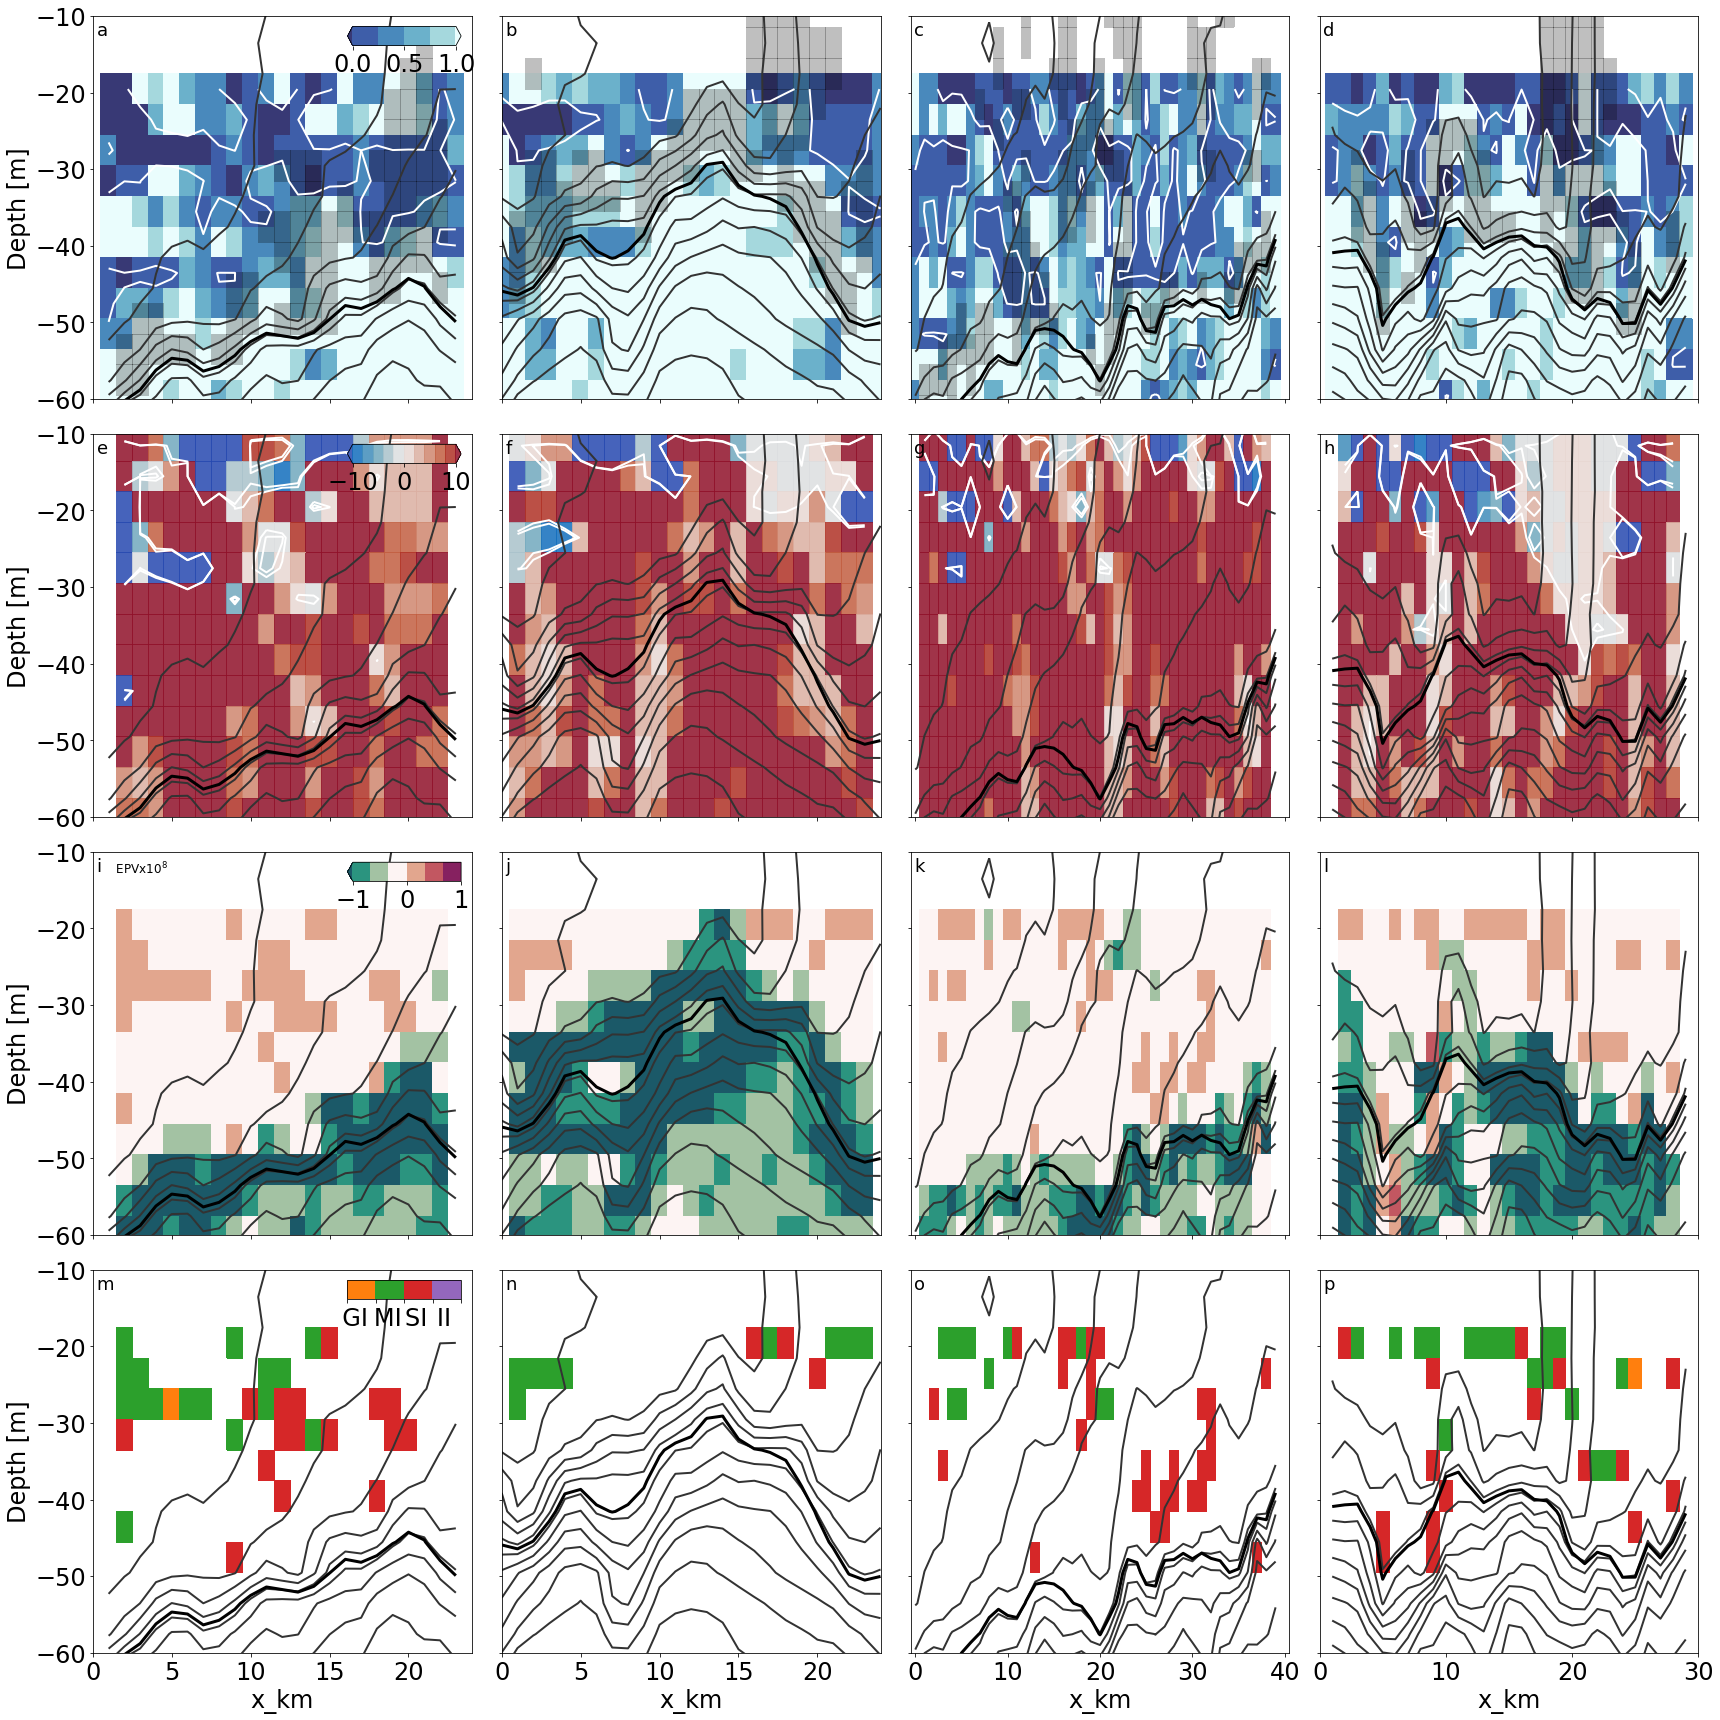

In [7]:
# As above but with Rig instead of Rib, and Ro instead of Ro_geo for Submeso analysis

x_lim, y_lim = [0,40], [-60,-10]
x_lim2 = [0,90]
mld_level = 0.1

si, nrows, ncols =  0, 4, 4
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*6.,nrows*6))
axs = axs.ravel()

si = 0  

### ==== Rig =====
# loop through each front of the 2 scanfish transects
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (0,1) # colorbar range
    lightice = cmocean.tools.crop_by_percent(cmo.ice, 25, which='min', N=None) # setup colormap
    # plot Rig as color contours
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rig.plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=5,ax=axs[si],ylim=y_lim,
                                                         add_colorbar=False,rasterized=True,cmap=lightice)
    # adding line contour of Rig=0.25
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rig.plot.contour(x='x_km',levels=[0.25],colors='w',ax=axs[si],linestyles='solid',
                                                                  ylim=y_lim,add_colorbar=False,rasterized=True)
    # improvement the look of the plot
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=True,colorbar_on=True)
    #if i == 0:
    #    axs[si].text(0.05,0.98,' Ri$^g$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1

### ==== Rib =====
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (-10,10)
    lightdiff = cmocean.tools.crop_by_percent(cmo.tarn, 50, which='both', N=None)
    lightbal = cmocean.tools.crop_by_percent(cmo.balance, 25, which='both', N=None)
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rib.plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=11,ax=axs[si],ylim=y_lim,
                                                         add_colorbar=False,rasterized=True,cmap=lightbal,alpha=0.85)
    p1 = ScanTransect_Fronts.sel(Transect=Trans).Rib.plot.contour(x='x_km',levels=[-1,1],colors='w',linestyles='solid',ax=axs[si],
                                                                  ylim=y_lim,add_colorbar=False,rasterized=True)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    #if i == 0:
    #    axs[si].text(0.05,0.98,' Ri$^b$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1

### ==== EPV =====
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (-1,1)
    lightcurl = cmocean.tools.crop_by_percent(cmo.curl, 25, which='both', N=None)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).Ertel_Potential_Vorticity*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPVx10$^{8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1
    
### ==== Instability =====
#si = 0  
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    var_range = (1,5)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).StableGravMixSymInert_Rig.
          where(ScanTransect_Fronts.sel(Transect=Trans).Ertel_Potential_Vorticity>0).
          where(ScanTransect_Fronts.sel(Transect=Trans).StableGravMixSymInert_Rig>0).
          plot(x='x_km',vmin=var_range[0],vmax=var_range[1],levels=5,ax=axs[si],ylim=y_lim,
               add_colorbar=False,rasterized=True,colors=plt.cm.tab10.colors[1:5]))
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,
                                    colorbar_on=False,lat_on_top=False)    
    if i == 0:
        cbaxes = inset_axes(axs[si], width="30%", height="5%", loc=1) 
        cbp = plt.colorbar(p1, cax=cbaxes, orientation='horizontal')
        cbp.ax.set_xticklabels(['  GI','   MI','   SI','   II'])  # relabeling colorbar
        #axs[si].text(0.05,0.98,' Instability Analysis', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',
        #             fontsize=12)
    if i < 2: axs[si].set_xlim(0,24)
    if i ==3: axs[si].set_xlim(0,30)
    si = si+1

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p'
                                   ,'','','','','','','','')),loc=(0.01,0.95),size=18)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_sections_filament_Ri_EPV_Instabilities_V2_Rig.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

In [6]:
ScanTransect_Fronts

<xarray.Dataset>
Dimensions:                    (Transect: 4, x_m: 41, x_m_left: 41, z: 39, z_left: 39)
Coordinates:
  * z                          (z) float64 -1.55 -5.55 -9.55 ... -149.6 -153.6
    Pressure                   (Transect, z) float64 1.56 5.587 ... 150.6 154.6
    lon                        (Transect, x_m) float64 nan 11.79 ... nan nan
    time_secs                  (Transect, x_m) float64 nan 1.479e+18 ... nan nan
    x_km                       (x_m) float64 0.0 1.0 2.0 3.0 ... 38.0 39.0 40.0
    lat                        (Transect, x_m) float64 nan -26.82 ... nan nan
  * x_m                        (x_m) float64 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
  * Transect                   (Transect) <U9 'ST1_south' ... 'ST2_north'
  * z_left                     (z_left) float64 0.45 -3.55 ... -147.6 -151.6
  * x_m_left                   (x_m_left) float64 -500.0 500.0 ... 3.95e+04
Data variables:
    trajectory                 (Transect) int32 -853839161 ... -853839161
    vship                      (Transect, x_m) float64 nan -1.862 ... nan nan
    across_fil                 (Transect, x_m, z) float64 nan nan ... nan nan
    uship                      (Transect, x_m) float64 nan 0.9805 ... nan nan
    along_fil                  (Transect, x_m, z) float64 nan nan ... nan nan
    tr_temp                    (Transect, x_m) float64 nan 17.52 ... nan nan
    pg                         (Transect, x_m, z) float64 nan nan ... nan nan
    pflag                      (Transect, x_m, z) float64 nan nan ... nan nan
    heading                    (Transect, x_m) float64 nan 146.7 ... nan nan
    depth                      (Transect, x_m, z) float64 nan nan ... nan nan
    amp                        (Transect, x_m, z) float64 nan nan ... nan nan
    CT                         (Transect, x_m, z) float64 nan nan ... nan nan
    SA                         (Transect, x_m, z) float64 nan nan ... nan nan
    sigma_0                    (Transect, x_m, z) float64 nan nan ... nan nan
    fluor                      (Transect, x_m, z) float64 nan nan ... nan nan
    o2                         (Transect, x_m, z) float64 nan nan ... nan nan
    x_m_full                   (Transect, x_m) float64 nan 8.378e+05 ... nan nan
    fo                         float64 -6.561e-05
    dx                         float64 1e+03
    dz                         float64 -4.0
    dx_left                    float64 1e+03
    dz_left                    float64 -4.0
    db_dx                      (Transect, x_m, z) float64 nan nan ... nan nan
    db_dz                      (Transect, x_m, z) float64 nan nan ... nan nan
    dv_dx                      (Transect, x_m, z) float64 nan nan ... nan nan
    dv_dz                      (Transect, x_m, z) float64 nan nan ... nan nan
    du_dz                      (Transect, x_m, z) float64 nan nan ... nan nan
    relative_vorticity         (Transect, x_m, z) float64 nan nan ... nan nan
    Ro                         (Transect, x_m, z) float64 nan nan ... nan nan
    MLD                        (Transect, x_m, z) float64 nan nan ... nan nan
    db_dx_zl                   (Transect, x_m, z_left) float64 nan nan ... nan
    db_dzl                     (Transect, x_m, z_left) float64 nan nan ... nan
    dv_dx_zl                   (Transect, x_m, z_left) float64 nan nan ... nan
    dv_dzl                     (Transect, x_m, z_left) float64 nan nan ... nan
    du_dzl                     (Transect, x_m, z_left) float64 nan nan ... nan
    Ertel_Potential_Vorticity  (Transect, x_m, z_left) float64 nan nan ... nan
    EPV_vertical               (Transect, x_m, z_left) float64 nan nan ... nan
    EPV_baroclinic             (Transect, x_m, z_left) float64 nan nan ... nan
    Rib                        (Transect, x_m, z_left) float64 nan nan ... nan
    Rig                        (Transect, x_m, z_left) float64 nan nan ... nan
    ang_Rib                    (Transect, x_m, z_left) float64 nan nan ... nan
    ang2_Rib                   (Transect, 

##### Plotting breakdown of EPV into baroclinic and vertical components

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


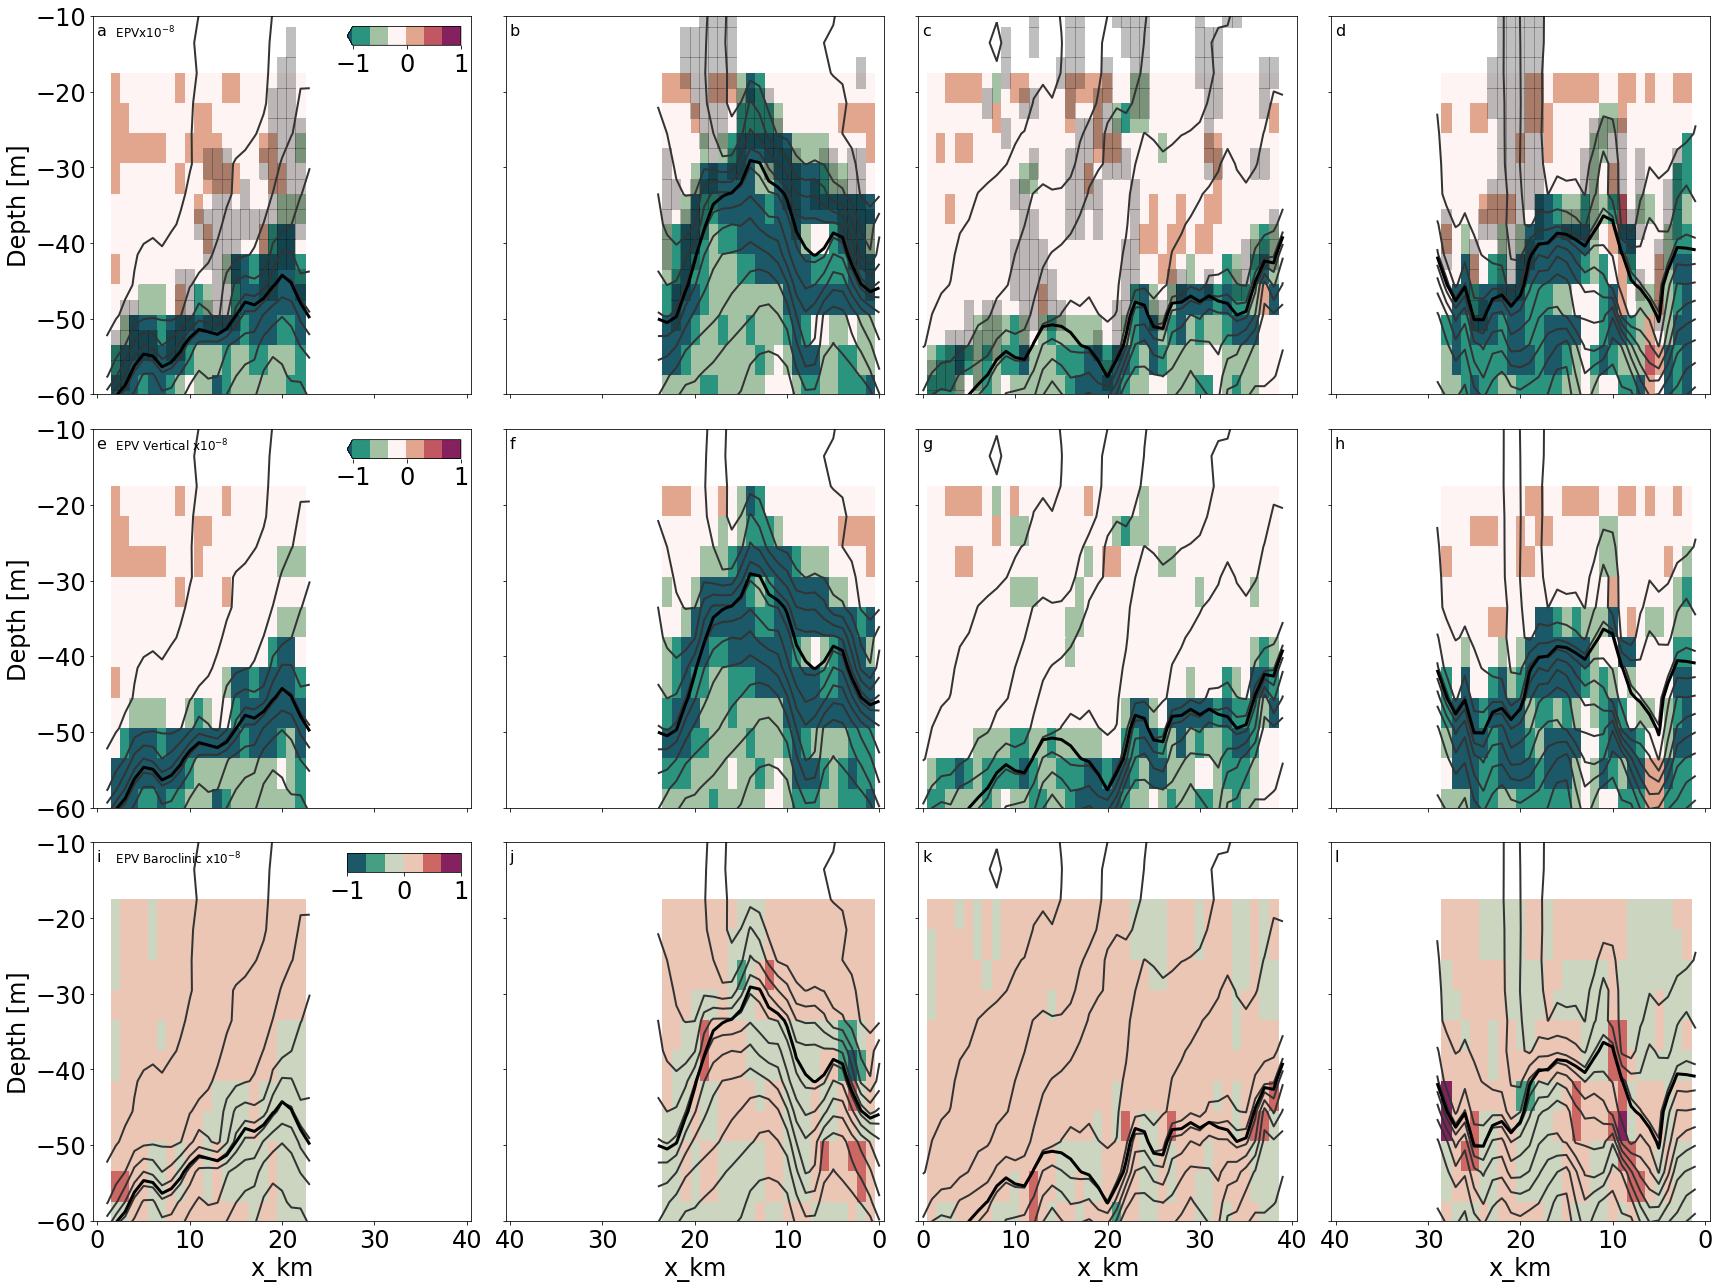

In [9]:
x_lim, y_lim = [65-12.5,0], [-60,-10]
x_lim2 = [0,90]
mld_level = 0.1

si, nrows, ncols =  0, 3, 4
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*6.,nrows*6))
axs = axs.ravel()

si = 0  
lightcurl = cmocean.tools.crop_by_percent(cmo.curl, 25, which='both', N=None)
### ==== EPV =====
var_range = (-1,1)
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).Ertel_Potential_Vorticity*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=True,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPVx10$^{-8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=12)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1
    
for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).EPV_vertical*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPV Vertical x10$^{-8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',
                     fontsize=12)
    axs[si].set_xticklabels(''), axs[si].set_xlabel('')
    si = si+1

for i, Trans in enumerate(ScanTransect_Fronts.Transect):
    #lightcurl = cmocean.tools.crop_by_percent(cmo.curl, 25, which='both', N=None)
    p1 = (ScanTransect_Fronts.sel(Transect=Trans).EPV_baroclinic*1e8).plot(x='x_km',vmin=var_range[0],vmax=var_range[1],
                                                        levels=7,ax=axs[si],ylim=y_lim,add_colorbar=False,rasterized=True,cmap=lightcurl)
    nice_plot_4fronts(i,ScanTransect_Fronts.sel(Transect=Trans),axs[si],var_range=var_range,h_grad_on=False,colorbar_on=True)
    if i == 0:
        axs[si].text(0.05,0.98,' EPV Baroclinic x10$^{-8}$', transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',
                     fontsize=12)
    si = si+1

label_axes(fig,labels=np.array(('a','b','c','d','e','f','g','h','i','j','k','l'
                                   ,'','','','','')),loc=(0.01,0.95),size=16)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_sections_filament_EPV_breakdown.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')